# Часть 1

#### Выбор архитектуры:

1. **Graph Convolutional Network (GCN):**

- **Плюсы:**
  - Учет контекста и локальных зависимостей.
  - Сравнительно легко обучить.

- **Минусы:**
  - Может ограничиваться локальными зависимостями, игнорируя глобальные паттерны.

2. **GraphSAGE (Graph Sample and Aggregation):**

- **Плюсы:**
  - Учет долгосрочных зависимостей.
  - Адаптирован для изменяющихся предпочтений.

- **Минусы:**
  - Может требовать больше вычислительных ресурсов при обработке больших графов.

3. **Graph Attention Network (GAT):**

- **Плюсы:**
  - Учет важности соседей.
  - Способен выявлять ключевые паттерны.

- **Минусы:**
  - Может быть вычислительно сложным при больших графах.

4. **Deep Graph Infomax (DGI):**

- **Плюсы:**
  - Создание информативных представлений.
  - Эффективное использование взаимной информации.

- **Минусы:**
  - Могут потребоваться дополнительные усилия для настройки параметров.

5. **Колоборативная фильтрация (CF):**
  - **Плюсы:** 
    - CF способна учитывать взаимодействие между пользователями и контентом, что может быть важно для предсказания пользовательских предпочтений.
  - **Минусы:** 
    - CF не учитывает контент, что может быть важно для предсказания пользовательских предпочтений в контексте разнообразного стримингового контента.

#### Обработка данных:

1. **Предобработка временных меток:**
   - Преобразование временных меток в удобный формат (например, в секунды с начала наблюдений) для лучшей интерпретации данных в нейросетевых моделях.

2. **Создание последовательности взаимодействий:**
   - Составление последовательности взаимодействий пользователя со стримерами в виде временных рядов, что позволяет учитывать динамику интересов пользователя.

#### Обучение и Оценка:

1. **Метрики:**
   - Метрики, такие как Precision, Recall и F1-score, помогут оценить точность предсказаний.

2. **Обучение на обучающей выборке:**
   - Разделение данных на обучающую и тестовую выборки.
   - Применение метода кросс-валидации для оптимизации гиперпараметров.

3. **Учет проблем переобучения и недообучения:**
   - Применение регуляризации и методов управления скоростью обучения для предотвращения переобучения.
   - Мониторинг кривых обучения для предотвращения недообучения.

#### Проблемы и Возможные Улучшения:

1. **Обработка холодного старта:**
   - Использование методов, таких как контентная фильтрация, для предсказания предпочтений новых пользователей или стримеров.

2. **Управление разреженностью данных:**
   - Применение методов матричного разложения или внедрение методов для работы с разреженными данными.

3. **Актуализация модели:**
   - Регулярное обновление модели с использованием новых данных для учета изменений в предпочтениях пользователей.

# Часть 2

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

In [4]:
import csv
import bokeh
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy import sparse 

In [12]:
header1 = ["User ID", "Stream ID", "Streamer Username", "Time Start", "Time Stop"]


df = pd.read_csv("full_a.csv", nrows = 1e5, header = None, names = header1)
df[df['User ID'] == 2]

,User ID,Stream ID,Streamer Username,Time Start,Time Stop
44,2,34302820672,mattie,4969,4974
45,2,34342297872,goldglove,5334,5337
46,2,34355796976,goldglove,5476,5478
47,2,34362322016,rtgamecrowd,5554,5566
48,2,34396737984,carlosstory,5914,5918
49,2,34396886576,witwix,5910,5919
50,2,34410905408,witwix,6073,6076
51,2,34411115296,witwix,6077,6081


In [25]:
df.duplicated().sum()

0

## EDA

In [27]:
#Сколько стримеров люди обычно смотрят?
df['Streamers Watched'] = df.groupby(['User ID'])['Streamer Username'].transform('count')
df

,User ID,Stream ID,Streamer Username,Time Start,Time Stop,Streamers Watched
0,1,33827518864,lirik,25,26,44
1,1,33870289680,giantwaffle,457,460,44
2,1,33876317008,blacklisted86,471,472,44
3,1,33882713200,cohhcarnage,544,550,44
4,1,33885628720,lirik,586,588,44
...,...,...,...,...,...,...
99995,3354,33853518400,handongsuk,255,256,5
99996,3354,33853894096,horusb,254,255,5
99997,3354,33879776560,pacific8815,517,518,5
99998,3354,33881001328,nanajam777,517,519,5


In [28]:
#Проверим
df[df['User ID'] == 3354]

,User ID,Stream ID,Streamer Username,Time Start,Time Stop,Streamers Watched
99995,3354,33853518400,handongsuk,255,256,5
99996,3354,33853894096,horusb,254,255,5
99997,3354,33879776560,pacific8815,517,518,5
99998,3354,33881001328,nanajam777,517,519,5
99999,3354,33881473696,yapyap30,538,539,5


<AxesSubplot: xlabel='Streamers Watched', ylabel='Count'>

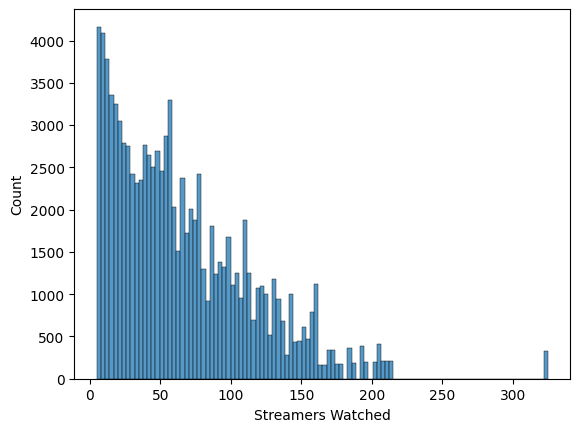

In [29]:
sns.histplot(df['Streamers Watched'])

<AxesSubplot: xlabel='Streamers Watched', ylabel='Count'>

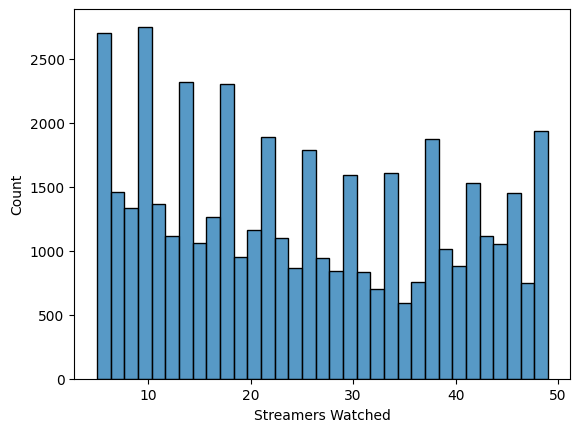

In [30]:
temp = df[df['Streamers Watched'] < 50]['Streamers Watched']
sns.histplot(temp)

In [31]:
visits = df.groupby(['Streamer Username', "User ID"])['User ID'].size().reset_index(name="Visits")
visits

,Streamer Username,User ID,Visits
0,03supreme30,2179,1
1,092288c,366,1
2,0bsess1,1741,1
3,0ciris,2834,1
4,0miki0_,1698,4
...,...,...,...
48777,zzamtiger0310,3132,2
48778,zzektv,3088,1
48779,zzogur,1993,2
48780,zzosher,977,1


In [32]:
df = df.merge(visits, on = ["Streamer Username", "User ID"], how = "left")

In [33]:
df

,User ID,Stream ID,Streamer Username,Time Start,Time Stop,Streamers Watched,Visits
0,1,33827518864,lirik,25,26,44,9
1,1,33870289680,giantwaffle,457,460,44,2
2,1,33876317008,blacklisted86,471,472,44,5
3,1,33882713200,cohhcarnage,544,550,44,3
4,1,33885628720,lirik,586,588,44,9
...,...,...,...,...,...,...,...
99995,3354,33853518400,handongsuk,255,256,5,1
99996,3354,33853894096,horusb,254,255,5,1
99997,3354,33879776560,pacific8815,517,518,5,1
99998,3354,33881001328,nanajam777,517,519,5,1


In [34]:
#Что это за люди, у которых в стримах есть преданные люди?
df[df['Visits'] > 20]

,User ID,Stream ID,Streamer Username,Time Start,Time Stop,Streamers Watched,Visits
903,14,33837280576,admiralbulldog,87,93,98,26
906,14,33851487648,admiralbulldog,229,238,98,26
910,14,33911487376,admiralbulldog,805,813,98,26
916,14,33950256512,admiralbulldog,1235,1248,98,26
927,14,34020486352,admiralbulldog,1952,1968,98,26
...,...,...,...,...,...,...,...
99367,3326,34333201520,mobilmobil,5258,5282,159,25
99380,3326,34371890288,mobilmobil,5638,5648,159,25
99383,3326,34375216640,mobilmobil,5683,5697,159,25
99386,3326,34388100592,mobilmobil,5829,5840,159,25


In [35]:
#Топ стримеров

temp = df[df['Visits'] > 10]
temp = temp[['Streamer Username', 'User ID']]
temp = temp.drop_duplicates()
temp = temp.groupby(['Streamer Username']).size().reset_index(name="Loyal Viewers").sort_values(by = ['Loyal Viewers'])
temp[temp['Loyal Viewers'] > 5]

,Streamer Username,Loyal Viewers
241,moonmoon_ow,6
69,chocotaco,6
412,ybicanoooobov,6
237,mobilmobil,7
110,elwind,7
147,hanryang1125,7
7,admiralbulldog,7
261,noway4u_sir,8
255,ninja,8
146,handongsuk,8


In [36]:
df['Watch Time'] = df['Time Stop'] - df['Time Start']
df

,User ID,Stream ID,Streamer Username,Time Start,Time Stop,Streamers Watched,Visits,Watch Time
0,1,33827518864,lirik,25,26,44,9,1
1,1,33870289680,giantwaffle,457,460,44,2,3
2,1,33876317008,blacklisted86,471,472,44,5,1
3,1,33882713200,cohhcarnage,544,550,44,3,6
4,1,33885628720,lirik,586,588,44,9,2
...,...,...,...,...,...,...,...,...
99995,3354,33853518400,handongsuk,255,256,5,1,1
99996,3354,33853894096,horusb,254,255,5,1,1
99997,3354,33879776560,pacific8815,517,518,5,1,1
99998,3354,33881001328,nanajam777,517,519,5,1,2


In [37]:
#1 просмотр = 10 минут

temp = df[df['Watch Time'] > 42] 
len(temp['Streamer Username'].unique())

42

In [38]:
list(temp['Streamer Username'].unique())

['greekgodx',
 'thijs',
 'esl_dota2',
 'xargon0731',
 'asiagodtonegg3be0',
 'a541021',
 'asmongold',
 'gn_gg',
 'summit1g',
 'tfue',
 'koil',
 'dota2ruhub',
 'fpsthailand',
 'amouranth',
 'burkeblack',
 'axtlol',
 'c_a_k_e',
 'zero',
 'mandiocaa1',
 'gaules',
 'overwatchleague',
 'dasmehdi',
 'quin69',
 'solary',
 'roshtein',
 'veelaprincess',
 'agraelus',
 'deriumspokemon',
 'kingrichard',
 'twistonfire',
 'toqtir',
 'vlad_boroda',
 'riotgames',
 'reckful',
 'fifatargrean',
 'anniefuchsia',
 'sodapoppin',
 'theno1alex',
 'maximilian_dood',
 'playhearthstone',
 'manvsgame',
 'welovegames']

In [39]:
#Стримеры, у которых есть хотя бы один зритель, смотрят их более 2 часов
temp = df[df['Watch Time'] > 12] 
len(temp['Streamer Username'].unique())

1690

In [40]:
df

,User ID,Stream ID,Streamer Username,Time Start,Time Stop,Streamers Watched,Visits,Watch Time
0,1,33827518864,lirik,25,26,44,9,1
1,1,33870289680,giantwaffle,457,460,44,2,3
2,1,33876317008,blacklisted86,471,472,44,5,1
3,1,33882713200,cohhcarnage,544,550,44,3,6
4,1,33885628720,lirik,586,588,44,9,2
...,...,...,...,...,...,...,...,...
99995,3354,33853518400,handongsuk,255,256,5,1,1
99996,3354,33853894096,horusb,254,255,5,1,1
99997,3354,33879776560,pacific8815,517,518,5,1,1
99998,3354,33881001328,nanajam777,517,519,5,1,2


In [42]:
df = temp
df

,User ID,Stream ID,Streamer Username,Time Start,Time Stop,Streamers Watched,Visits,Watch Time,User Total Time Watching Streams,Total Time Watching Streamer,Percentage of Time Watching Streamer
0,1,33827518864,lirik,25,26,44,9,1,124,23,18.548387
1,1,33870289680,giantwaffle,457,460,44,2,3,124,4,3.225806
2,1,33876317008,blacklisted86,471,472,44,5,1,124,10,8.064516
3,1,33882713200,cohhcarnage,544,550,44,3,6,124,9,7.258065
4,1,33885628720,lirik,586,588,44,9,2,124,23,18.548387
...,...,...,...,...,...,...,...,...,...,...,...
99995,3354,33853518400,handongsuk,255,256,5,1,1,6,1,16.666667
99996,3354,33853894096,horusb,254,255,5,1,1,6,1,16.666667
99997,3354,33879776560,pacific8815,517,518,5,1,1,6,1,16.666667
99998,3354,33881001328,nanajam777,517,519,5,1,2,6,2,33.333333


все еще считаю что нужно убрать id стримера и зрителя, так как они не несут никакой информации

## RecSys - Колоборативная фильтрация

https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F

Будем использовать User-based nearest neighbor метод для рекомендаций. вероятные проблемы - холодный старт, Когда пользователь новый и у него нет истории просмотров, а также проблема с рекомендациями для пользователей с небольшим количеством просмотров, да и вообще очень большой датасет.

In [44]:
df['Streamer ID'] = df['Streamer Username'].astype('category')
df['Streamer ID'] = df["Streamer ID"].cat.codes
df

,User ID,Stream ID,Streamer Username,Time Start,Time Stop,Streamers Watched,Visits,Watch Time,User Total Time Watching Streams,Total Time Watching Streamer,Percentage of Time Watching Streamer,Streamer ID
0,1,33827518864,lirik,25,26,44,9,1,124,23,18.548387,8748
1,1,33870289680,giantwaffle,457,460,44,2,3,124,4,3.225806,5472
2,1,33876317008,blacklisted86,471,472,44,5,1,124,10,8.064516,1733
3,1,33882713200,cohhcarnage,544,550,44,3,6,124,9,7.258065,2800
4,1,33885628720,lirik,586,588,44,9,2,124,23,18.548387,8748
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3354,33853518400,handongsuk,255,256,5,1,1,6,1,16.666667,5901
99996,3354,33853894096,horusb,254,255,5,1,1,6,1,16.666667,6283
99997,3354,33879776560,pacific8815,517,518,5,1,1,6,1,16.666667,11563
99998,3354,33881001328,nanajam777,517,519,5,1,2,6,2,33.333333,10618


In [46]:
def sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df['Total Time Watching Streamer'].values,(df['User ID'].values, df['Streamer ID'].values)))
    return sparse_data

df1 = sparse_matrix(df)
df1

<3355x17702 sparse matrix of type '<class 'numpy.int64'>'
	with 48782 stored elements in Compressed Sparse Row format>

In [47]:
def similarity(sparse_matrix, streamers, streamer_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_streamers = streamers.loc[streamer_id][0], similarity[streamer_id].count_nonzero()
    return no_of_similar_streamers

In [48]:
streamers = df[['Streamer Username', 'Streamer ID', "User ID", "Total Time Watching Streamer"]]
streamers = streamers.set_index('Streamer ID').sort_index()
streamers

,Streamer Username,User ID,Total Time Watching Streamer
Streamer ID,,,
0,03supreme30,2179,1
1,092288c,366,3
2,0bsess1,1741,1
3,0ciris,2834,1
4,0miki0_,1698,5
...,...,...,...
17698,zzektv,3088,1
17699,zzogur,1993,2
17699,zzogur,1993,2


In [51]:
df2 = df[['Streamer Username', 'Streamer ID', "User ID", "Total Time Watching Streamer"]]
df2  = df2 .drop_duplicates(subset = "Streamer Username")
df2  = df2 .reset_index()
df2 

,index,Streamer Username,Streamer ID,User ID,Total Time Watching Streamer
0,0,lirik,8748,1,23
1,1,giantwaffle,5472,1,4
2,2,blacklisted86,1733,1,10
3,3,cohhcarnage,2800,1,9
4,5,sodapoppin,14275,1,30
...,...,...,...,...,...
17697,99971,cketuve,2700,3352,10
17698,99972,musevernie666,10480,3352,7
17699,99973,klouis1935,8018,3352,4
17700,99982,iltanzen,6532,3353,2


In [53]:
pt_df = df2.pivot(values = 'Total Time Watching Streamer', index = 'User ID', columns = 'Streamer ID').fillna(0)
pt_df

Streamer ID,0,1,2,3,4,5,6,7,8,9,...,17692,17693,17694,17695,17696,17697,17698,17699,17700,17701
User ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
pt = pt_df.values
user_timewatched_mean = np.mean(pt, axis = 1)
pt_norm = pt - user_timewatched_mean.reshape(-1,1)

In [56]:
u, s, v = svds(pt_norm, k = 50)
s = np.diag(s)

In [57]:
all_user_predicted_timewatched = np.dot(np.dot(u, s), v) + user_timewatched_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_timewatched, columns = pt_df.columns)

In [60]:
filtered_df = df[['Streamer ID', 'Streamer Username']]
filtered_df = filtered_df.drop_duplicates(subset = "Streamer Username")
filtered_df

,Streamer ID,Streamer Username
0,8748,lirik
1,5472,giantwaffle
2,1733,blacklisted86
3,2800,cohhcarnage
5,14275,sodapoppin
...,...,...
99971,2700,cketuve
99972,10480,musevernie666
99973,8018,klouis1935
99982,6532,iltanzen


In [61]:
original_ratings_df = df[['Streamer Username', 'Streamer ID', "User ID", "Total Time Watching Streamer"]]
original_ratings_df = original_ratings_df.drop_duplicates(subset = "Streamer Username")
original_ratings_df= original_ratings_df.reset_index()
original_ratings_df = original_ratings_df[['User ID', 'Streamer ID', 'Total Time Watching Streamer']]
original_ratings_df 

,User ID,Streamer ID,Total Time Watching Streamer
0,1,8748,23
1,1,5472,4
2,1,1733,10
3,1,2800,9
4,1,14275,30
...,...,...,...
17697,3352,2700,10
17698,3352,10480,7
17699,3352,8018,4
17700,3353,6532,2


In [62]:
def recommend_streamers(preds_df, userID, filtered_df, original_ratings_df, num_recommendations=5):
    
    user_row_number = userID - 1 
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)
    
    user_data = original_ratings_df[original_ratings_df['User ID'] == userID]
    user_full = (user_data.merge(filtered_df, how = 'left', left_on = 'Streamer ID', right_on = 'Streamer ID').
                     sort_values(['Total Time Watching Streamer'], ascending=False))
    
    recommendations = (filtered_df[~filtered_df['Streamer ID'].isin(user_full['Streamer ID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', 
               left_on = 'Streamer ID',
               right_on = 'Streamer ID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations


In [ ]:
already_rated, predictions = recommend_streamers(preds_df, 101, filtered_df, original_ratings_df, 10)

In [64]:
already_rated.head(10)

,User ID,Streamer ID,Total Time Watching Streamer,Streamer Username
11,101,6787,23,itshnik
3,101,3249,21,danilycho
4,101,17179,17,y_e_t_t_y
24,101,370,4,agressor_in_the_void
23,101,1233,4,b_u_l_o_c_h_k_a
20,101,1243,3,babkamurder
14,101,5640,2,gorezones
25,101,5934,2,hardflix
13,101,14067,2,skoomacat
18,101,1178,2,ayr1s


In [65]:
predictions

,Streamer ID,Streamer Username
12916,16814,wixiban25
12913,12683,reddirtranch
4755,11809,pestily
4927,2180,call_me_piotr
14767,8148,kregme
12868,13071,rossmum
12893,15822,torniquethd
12880,1642,bigrudie
17014,8244,kusieru
13008,15480,theorigamiguru
